In [1]:
import CASBI.utils as utils
from CASBI.generator import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
training_set = pd.read_parquet('../../data/dataframe/dataframe.parquet')

conditions = training_set.columns.difference(['feh', 'ofe', 'Galaxy_name'], sort=False)
conditions_set = training_set[conditions]

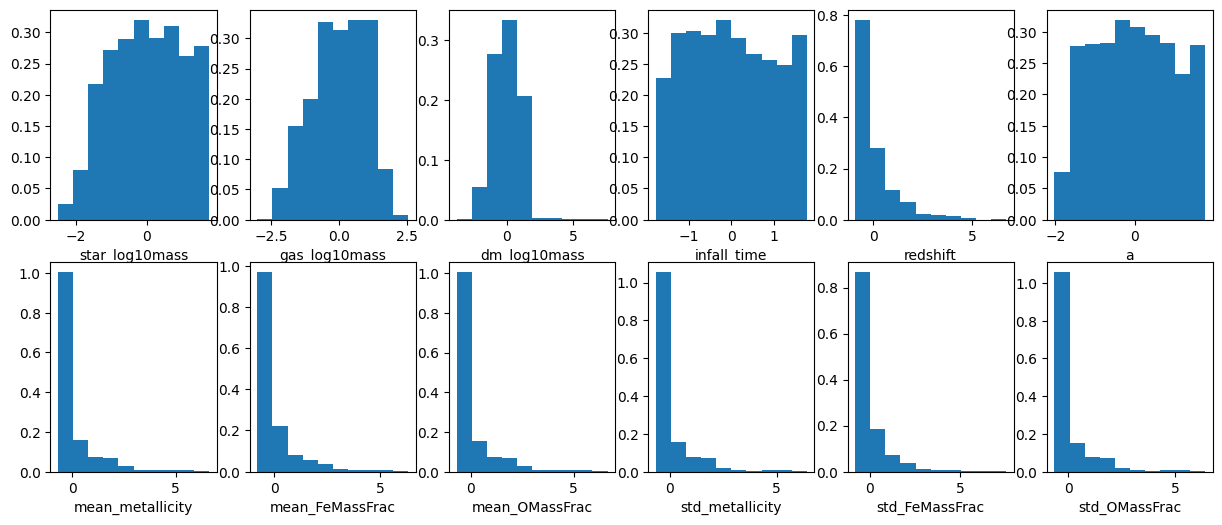

In [4]:
fig = plt.figure(figsize=(15, 6))
for i, con in enumerate(conditions_set.columns):
    ax = fig.add_subplot(2, int(len(conditions_set.columns)/2), i+1)
    ax.hist(conditions_set[con], density=True)
    ax.set_xlabel(con)
    

In [6]:
def get_even_space_sample(df_mass_masked):
    '''
    Given a dataframe of galaxy in a range of mass, it returns 20 equally infall time spaced samples  
    '''
    len_infall_time = len(df_mass_masked['infall_time'].unique())
    index_val_time = np.linspace(0, len_infall_time-1, 20)
    time = np.sort(df_mass_masked['infall_time'].unique())[index_val_time.astype(int)]
    df_time = pd.DataFrame(columns=df_mass_masked.columns)
    for t in time:
        temp = df_mass_masked[df_mass_masked['infall_time']==t]
        galaxy_temp = temp.sample(1)['Galaxy_name'].values[0]
        df_galaxy = df_mass_masked[df_mass_masked['Galaxy_name']==galaxy_temp]
        df_time = pd.concat([df_time, df_galaxy])
    return df_time
    
    
def load_train_objs(train_set):
    
    low_percentile_mass, high_percentile_mass = np.percentile(train_set['star_log10mass'], 25), np.percentile(train_set['star_log10mass'], 75)
    low_mass = get_even_space_sample(train_set[train_set['star_log10mass']<=low_percentile_mass])
    intermediate_mass = get_even_space_sample(train_set[(train_set['star_log10mass']>low_percentile_mass) & (train_set['star_log10mass']<high_percentile_mass)])
    high_mass = get_even_space_sample(train_set[train_set['star_log10mass']>=high_percentile_mass])
    val_set = pd.concat([low_mass, intermediate_mass, high_mass])
    
    train_set = train_set[~train_set['Galaxy_name'].isin(val_set['Galaxy_name'])]
    
    low_percentile_mass, high_percentile_mass = np.percentile(train_set['star_log10mass'], 25), np.percentile(train_set['star_log10mass'], 75)
    low_mass = get_even_space_sample(train_set[train_set['star_log10mass']<=low_percentile_mass])
    intermediate_mass = get_even_space_sample(train_set[(train_set['star_log10mass']>low_percentile_mass) & (train_set['star_log10mass']<high_percentile_mass)])
    high_mass = get_even_space_sample(train_set[train_set['star_log10mass']>=high_percentile_mass])
    test_set = pd.concat([low_mass, intermediate_mass, high_mass])
    
    train_set = train_set[~train_set['Galaxy_name'].isin(test_set['Galaxy_name'])]
    
    return train_set, val_set, test_set

In [7]:
train_set, val_set, test_set = load_train_objs(training_set)

/tmp/ipykernel_741729/4132125250.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_time = pd.concat([df_time, df_galaxy])
/tmp/ipykernel_741729/4132125250.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_time = pd.concat([df_time, df_galaxy])
/tmp/ipykernel_741729/4132125250.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtyp

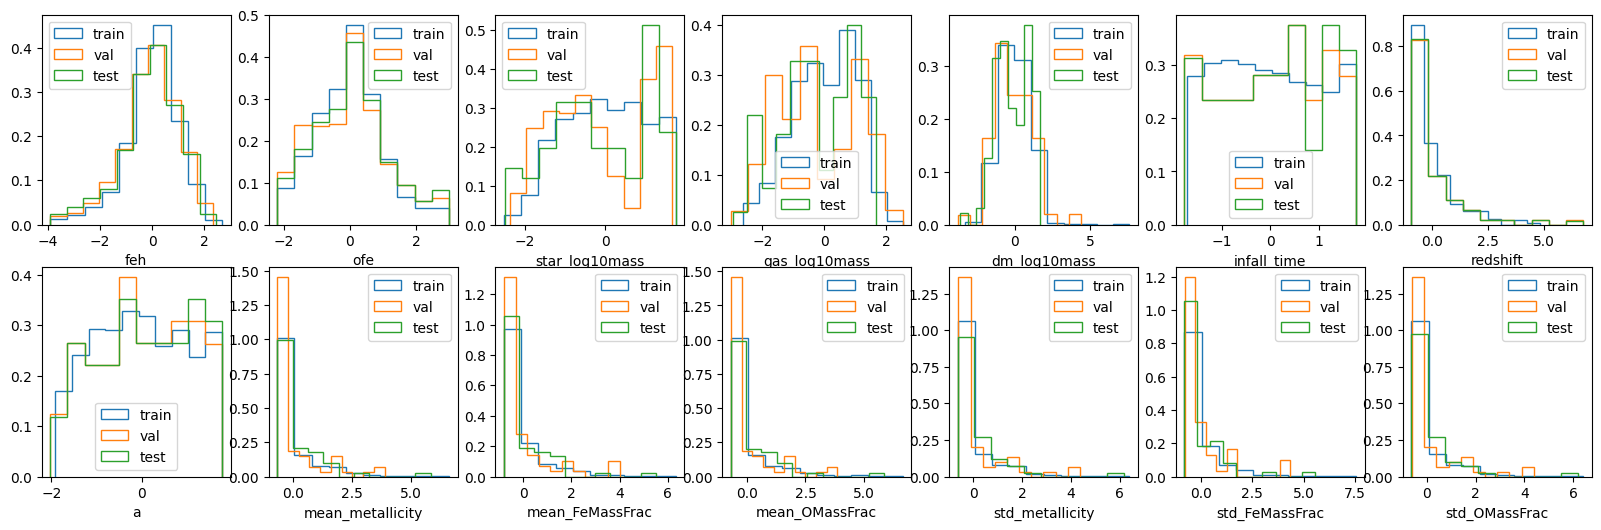

In [8]:
fig = plt.figure(figsize=(20, 6))
for i, con in enumerate(train_set.columns[:-1]):
    ax = fig.add_subplot(2, int(len(train_set.columns)/2), i+1)
    ax.hist(train_set[con], density=True, label='train', histtype='step')
    ax.hist(val_set[con], density=True, label='val', histtype='step')
    ax.hist(test_set[con], density=True, label='test', histtype='step')
    ax.legend()
    ax.set_xlabel(con)


In [3]:
training_set = training_set.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac', 'feh', 'ofe'], axis=1)
training_set = training_set.drop_duplicates()
training_set = training_set.drop('Galaxy_name', axis=1)

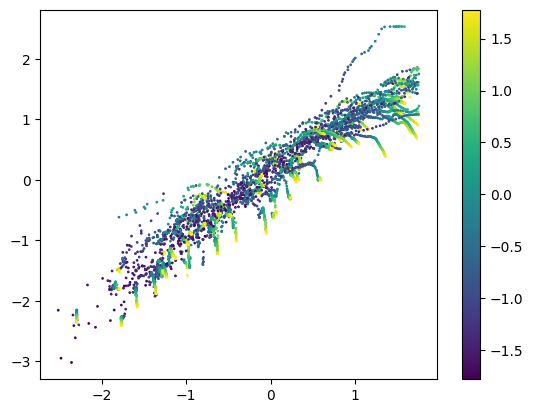

In [24]:
plt.scatter(training_set['star_log10mass'], training_set['gas_log10mass'], c=training_set['infall_time'], s=1)
plt.colorbar()

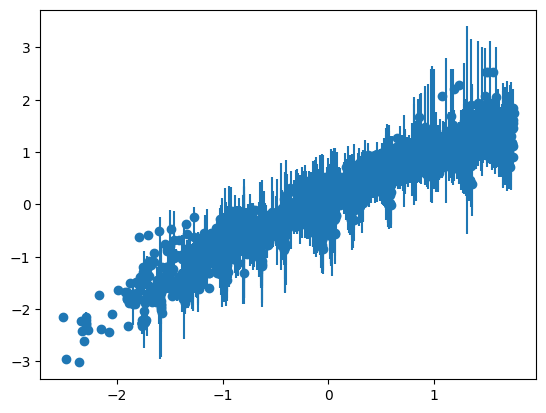

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins
num_bins = 4000

# Bin the x data
bins = np.linspace(training_set['star_log10mass'].min(), training_set['star_log10mass'].max(), num_bins)
bin_indices = np.digitize(training_set['star_log10mass'], bins)

# Calculate the mean and standard deviation within each bin
bin_means = [training_set['gas_log10mass'][bin_indices == i].mean() for i in range(1, len(bins))]
bin_stds = [(training_set['gas_log10mass'][bin_indices == i].max() - training_set['gas_log10mass'][bin_indices == i].min())   for i in range(1, len(bins))]

# Plot the mean and standard deviation
plt.errorbar((bins[1:] + bins[:-1]) / 2, bin_means, yerr=bin_stds, fmt='o')
plt.show()

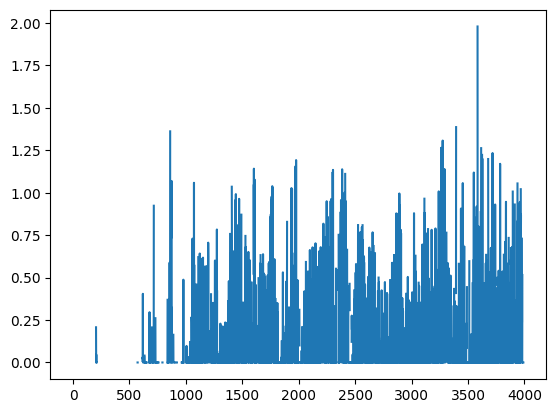

In [41]:
plt.plot(bin_stds)

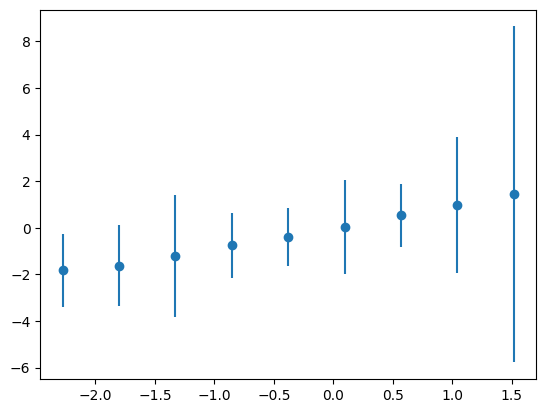

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins
num_bins = 10

# Bin the x data
bins = np.linspace(training_set['star_log10mass'].min(), training_set['star_log10mass'].max(), num_bins)
bin_indices = np.digitize(training_set['star_log10mass'], bins)

# Calculate the mean and standard deviation within each bin
bin_means = [training_set['dm_log10mass'][bin_indices == i].mean() for i in range(1, len(bins))]
bin_stds = [abs((training_set['dm_log10mass'][bin_indices == i].max() - training_set['gas_log10mass'][bin_indices == i].min()))   for i in range(1, len(bins))]

# Plot the mean and standard deviation
plt.errorbar((bins[1:] + bins[:-1]) / 2, bin_means, yerr=bin_stds, fmt='o')
plt.show()

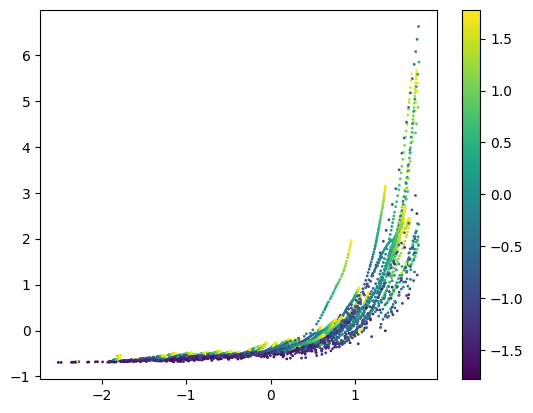

In [8]:
plt.scatter(training_set['star_log10mass'], training_set['mean_metallicity'], c=training_set['infall_time'], s=1)
plt.colorbar()

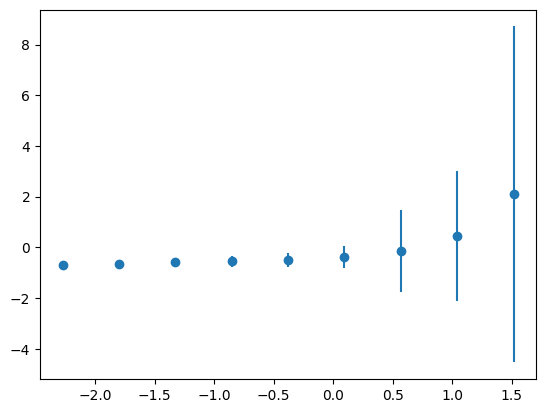

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of bins
num_bins = 10

# Bin the x data
bins = np.linspace(training_set['star_log10mass'].min(), training_set['star_log10mass'].max(), num_bins)
bin_indices = np.digitize(training_set['star_log10mass'], bins)

# Calculate the mean and standard deviation within each bin
bin_means = [training_set['mean_metallicity'][bin_indices == i].mean() for i in range(1, len(bins))]
bin_stds = [abs((training_set['mean_metallicity'][bin_indices == i].max() - training_set['mean_metallicity'][bin_indices == i].min()))   for i in range(1, len(bins))]

# Plot the mean and standard deviation
plt.errorbar((bins[1:] + bins[:-1]) / 2, bin_means, yerr=bin_stds, fmt='o')
plt.show()

In [12]:
bin_stds = [abs((training_set['mean_metallicity'][bin_indices == i].max() - training_set['mean_metallicity'][bin_indices == i].min()))   for i in range(1, len(bins))]
print(bin_stds)

[0.017160339265348545, 0.14325990172626557, 0.17955257238970035, 0.22303749960285857, 0.27011579830997673, 0.4529022387120865, 1.6257713475228712, 2.5661035273112347, 6.6262697946881985]


In [3]:
conditions_set = conditions_set.drop_duplicates().drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac', 'infall_time'], axis=1)
conditions_set

,star_log10mass,gas_log10mass,dm_log10mass,mean_metallicity,std_metallicity
0,-0.762074,-0.684708,-1.171100,-0.609069,-0.577905
500,-0.678236,-0.483013,-0.936042,-0.607008,-0.581887
1000,-0.388076,-0.151356,-0.585976,-0.605503,-0.562452
1500,-0.334419,-0.054883,-0.467195,-0.592765,-0.548277
2000,-0.319368,-0.041037,-0.362739,-0.550412,-0.531903
...,...,...,...,...,...
2196063,-1.275237,-1.500222,-0.888095,-0.543897,-0.477359
2196563,-1.275516,-1.507431,-0.897027,-0.543897,-0.477359
2197063,-1.275740,-1.516642,-0.906766,-0.543897,-0.477359
2197563,-1.275928,-1.530889,-0.914335,-0.543897,-0.477359


In [97]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
from pyro.nn import AutoRegressiveNN
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm


smoke_test = ('CI' in os.environ)
i = 3
base_dist = dist.Normal(torch.zeros(i).to('cuda'), torch.ones(i).to('cuda'))
spline_transform = T.spline_coupling(i, count_bins=8)
spline_transform = spline_transform.to('cuda')
arn = AutoRegressiveNN(i, [10*i, 10*i])

# Use NeuralAutoregressive transform with a Spline coupling layer
neural_transform = T.NeuralAutoregressive(arn, [16])
neural_transform = neural_transform.to('cuda')

flow_dist = dist.TransformedDistribution(base_dist, [spline_transform, spline_transform, spline_transform ], )

steps = 1 if smoke_test else 10_000
dataset = torch.tensor(conditions_set.values[:, :i].astype(float), dtype=torch.float).to('cuda')
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=7e-3)
for step in tqdm(range(steps+1)):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

  0%|          | 0/10001 [00:00<?, ?it/s]

step: 0, loss: 7.427488327026367


step: 500, loss: 1.3329308032989502
step: 1000, loss: 1.283395528793335
step: 1500, loss: 1.3007339239120483
step: 2000, loss: 1.231648564338684
step: 2500, loss: 1.261489987373352
step: 3000, loss: 1.252920150756836
step: 3500, loss: 1.1913752555847168
step: 4000, loss: 1.170915126800537
step: 4500, loss: 1.1782513856887817
step: 5000, loss: 1.1758760213851929
step: 5500, loss: 1.1211565732955933
step: 6000, loss: 1.1279454231262207
step: 6500, loss: 1.114250659942627
step: 7000, loss: 1.0905808210372925
step: 7500, loss: 1.1173279285430908
step: 8000, loss: 1.063504934310913
step: 8500, loss: 1.0787121057510376
step: 9000, loss: 1.0445983409881592
step: 9500, loss: 1.0156018733978271
step: 10000, loss: 1.1718628406524658


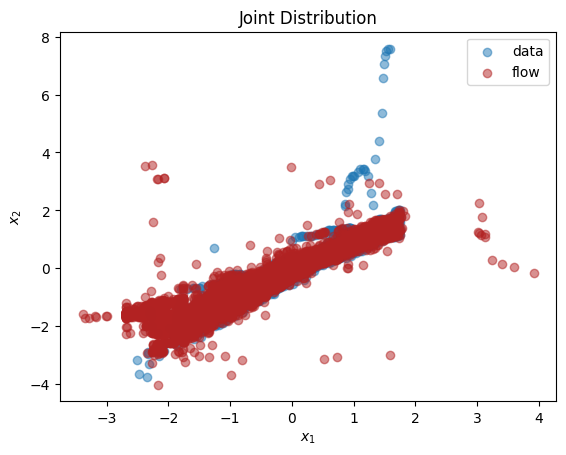

In [96]:
X_flow = flow_dist.sample(torch.Size([10000,])).detach().cpu()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
i= 2
plt.scatter(conditions_set.values[:,0], conditions_set.values[:,i], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,i], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()